In [1]:
import json

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# Get files from OSF ======================================================
def osf_listfiles(data_subproject="", token="", after_date=None):
    try:
        import osfclient
    except ImportError:
        raise ImportError("Please install 'osfclient' (`pip install osfclient`)")
    osf = osfclient.OSF(token=token).project(data_subproject)  # Connect to project
    storage = [s for s in osf.storages][0]  # Access storage component
    files = [
        {
            "name": file.name.replace(".csv", ""),
            "date": pd.to_datetime(file.date_created),
            "url": file._download_url,
            "size": file.size,
            "file": file,
        }
        for file in storage.files
    ]
    file = [f for f in storage.files][0]
    file.__dict__

    if after_date is not None:
        date = pd.to_datetime(after_date, format="%d/%m/%Y", utc=True)
        files = [f for f, d in zip(files, [f["date"] > date for f in files]) if d]
    return files

Incentivized ===================================================================

In [4]:
sona_credited = [
    27027,
    28388,
    29913,
    30605,
    30618,
    30623,
    30624,
    30633,
    30634,
    30636,
    30645,
    30644,
    30647,
    30660,
    30675,
    30694,
    30695,
    30722,
    30725,
    31729,
    30733,
    30737,
    30756,
    30760,
    30768,
    31770,
    30772,
    30777,
    30779,
    30784,
    31788,
    30791,
    30800,
    30804,
    30806,
    30809,
    30818,
    30839,
    30827,
    30844,
    30848,
    30850,
    30854,  # Doesn't show up in records
    30862,
    30872,
    30876,
    30884,
    30885,
    30889,
    30901,
    # 30935,   # Doesn't show up in records
    30956,
    30948,
    30954,
    30966,
    30993,
    31001,
    31003,
    31006,
    31018,
    31037,
    31047,
    31060,
    31065,
    31073,
    31080,
    31087,
    31100,
    31110,
    31101,
    31111,
    31114,
    31667,
    31673,
    31717,
    31720,
    31728,
    31731,
    31742,
    31753,
    31762,
    31766,
    31768,
    31771,
    31774,
    31777,
    31783,
    31787,
    31801,
    31807,
    31808,
    31810,
    31814,
    31822,
    31830,
    31833,
    31838,
    31843,
    31845,
    31849,
    31852,  # Awarded 0
    31857,
    31862,
    31863,
    31864,
    31865,
    31869,
    31874,
    31827,
    31852,
    31853,
    31867,
    31868,
    31885,
    31895,
    31902,
    31903,
    31911,
    31914,
    31915,
    31923,
    31925,
    31930,
    31935,
    31938,
    31943,
    31953,
    31961,  # Awarded half
    31967,
    31968,  # Awarded half
    31972,
    31978,
    31988,
    32012,
    32013,
    32014,
    32021,
    32030,
    32043,
    32045,
    32046,
    32047,
    32057,
    32058,
    32065,
    32067,
    32068,
    32078,
    32080,
    32085,
    32086,
    32097,
    32098,
    32106,
    32110,
    32114,
    32115,
    32133,
    32148,
    32160,
    32161,
    32165,
    32168,
    32180,
    32182,
    32184,
    32186,
    32188,
    32191,
    32244,
    32260,
]

In [11]:
token = "zYboMoukFI8HKabenQ35DH6tESHJo6oZll5BvOPma6Dppjqc2jnIB6sPCERCuaqO0UrHAa"  # Paste OSF token here to access private repositories
files = osf_listfiles(
    token=token,
    data_subproject="6xdz9",  # Data subproject ID
    after_date="13/12/2023",
)

In [12]:
# Loop through files ======================================================
alldata_sub = pd.DataFrame()  # Initialize empty dataframe
alldata_ig = pd.DataFrame()  # Initialize empty dataframe
prolific_ids = {}

In [13]:
for i, file in enumerate(files):
    print(f"File N°{i+1}/{len(files)}")

    if not alldata_sub.empty:
        if file["name"] in alldata_sub["Participant"].values:
            continue
    data = pd.read_csv(file["file"]._get(file["url"], stream=True).raw)


    # Participant ========================================================
    # data["screen"].unique()

    # Browser info -------------------------------------------------------
    browser = data[data["screen"] == "browser_info"].iloc[0]

    # Experimenter
    if "experimenter" in browser.index:
        experimenter = "Experimenter1"
    else:
        experimenter = browser["researcher"]
    if "prolific_id" in browser.index:
        if isinstance(browser["prolific_id"], str):
            experimenter = "Prolific"
    if isinstance(experimenter, float):
        experimenter = "Experimenter" + str(int(experimenter))

    df = pd.DataFrame(
        {
            "Participant": file["name"],
            "Experimenter": experimenter,
            "Experiment_Duration": data["time_elapsed"].max() / 1000 / 60,
            "Date_OSF": file["date"],
            "Date": browser["date"],
            "Time": browser["time"],
            "Browser": browser["browser"],
            "Mobile": browser["mobile"],
            "Platform": browser["os"],
            "Screen_Width": browser["screen_width"],
            "Screen_Height": browser["screen_height"],
        },
        index=[0],
    )

    if experimenter == "Prolific":
        id = browser["prolific_id"]
        if id not in [
            "5d9b60eb027b56001220d84e",
            "631745a70c7c585248df1a5d",
            "5714e0958adadb00098deed4",
            "59d4fac0d1ab390001da2e46",
            "5ed934c19e6b4a496cd6da06",
            "645bc6fcd55cf9db562b97f8",
        ]:
            prolific_ids[file["name"]] = id

    if "sona_id" in browser.index:
        if np.isnan(browser["sona_id"]) == False:
            id = int(browser["sona_id"])
            df["SONA_ID"] = id

    # Demographics -------------------------------------------------------
    demo1 = data[data["screen"] == "demographics_1"].iloc[0]
    demo1 = json.loads(demo1["response"])

    demo2 = data[data["screen"] == "demographics_2"].iloc[0]
    demo2 = json.loads(demo2["response"])

    df["Gender"] = demo1["gender"]
    df["Age"] = demo2["age"]

    # Education
    edu = demo1["education"]
    edu = "Bachelor" if "bachelor" in edu else edu
    edu = "Master" if "master" in edu else edu
    edu = "Doctorate" if "doctorate" in edu else edu
    edu = "High School" if "High school" in edu else edu
    df["Education"] = edu

    # Ethnicity
    race = demo2["ethnicity"].title().rstrip()
    race = (
        "Caucasian"
        if race
        in [
            "British",
            "White British",
            "Czech",
            "European",
            "Nederlander",
            "British White",
            "Bulgarian",
            "Caucasion",
            "Causasian",
            "English",
            "Greek",
            "Other White",
            "Polish",
            "White - Czech",
            "White (British)",
            "White Other",
            "White, British",
        ]
        else race
    )
    race = (
        "Mixed"
        if race
        in [
            "Caucasion Metis",
            "Mixed (White And Asian)",
            "Mixed Caucasian And Southeast Asian",
            "Mixed White",
            "Mixed/ Multiple Ethnic Backgrounds",
            "Mixt",
        ]
        else race
    )
    race = (
        "South Asian"
        if race in ["Indian", "Bengali", "British Indian", "Pakistani"]
        else race
    )
    race = "Asian" if race in ["Asian-British", "Asian British", "Chinese"] else race
    race = "Black" if race in ["Black African", "Black Carribean"] else race
    race = (
        "Other"
        if race
        in [
            "Native American",
            "Egyptian",
            "Filipino",
            "North  African",
            "Polynesian",
            "Turkish",
        ]
        else race
    )

    race = np.nan if race in [""] else race
    df["Ethnicity"] = race

    # Questionnaires =====================================================

    # Manual fix (2 first participants had duplicated questionnaires)
    if file["name"] in ["8va2haolh5", "exgf9of50l"]:
        data.loc[data["screen"][data["trial_type"] == "survey"].index, "screen"] = (
            "questionnaire_mist"
        )
        if file["name"] == "exgf9of50l":
            data = data.drop(data[data["screen"] == "questionnaire_mist"].index[1])
            data = data.drop(data[data["screen"] == "questionnaire_ipip6"].index[1])
        else:
            data = data.drop(data[data["screen"] == "questionnaire_mist"].index[0])
            data = data.drop(data[data["screen"] == "questionnaire_pid5"].index[0])

    df = df.copy()  # Defragment dataframe

    # Questionnaire Order ------------------------------------------------
    # Select all screens start _with 'questionnaire'
    order = data["screen"].str.startswith("questionnaire")
    order[order.isna()] = False
    order = list(data[order]["screen"])

    # PID-5 ---------------------------------------------------------------
    pid5 = data[data["screen"] == "questionnaire_pid5"].iloc[0]

    df["PID5_Duration"] = pid5["rt"] / 1000 / 60
    df["PID5_Order"] = order.index("questionnaire_pid5") + 1

    pid5 = json.loads(pid5["response"])
    for item in pid5:
        df["PID5_" + item] = pid5[item]

    # IPIP-6 --------------------------------------------------------------
    ipip6 = data[data["screen"] == "questionnaire_ipip6"].iloc[0]

    df["IPIP6_Duration"] = ipip6["rt"] / 1000 / 60
    df["IPIP6_Order"] = order.index("questionnaire_ipip6") + 1

    ipip6 = json.loads(ipip6["response"])
    for item in ipip6:
        df["IPIP6_" + item] = ipip6[item]

    # SSS -----------------------------------------------------------------
    sss = data[data["screen"] == "questionnaire_sss"].iloc[0]

    df["SSS_Duration"] = sss["rt"] / 1000 / 60
    df["SSS_Order"] = order.index("questionnaire_sss") + 1

    sss = json.loads(sss["response"])
    for item in sss:
        df[item] = sss[item]

    # MIST ----------------------------------------------------------------
    mist = data[data["screen"] == "questionnaire_mist"].iloc[0]

    df["MIST_Duration"] = mist["rt"] / 1000 / 60
    df["MIST_Order"] = order.index("questionnaire_mist") + 1

    mist = json.loads(mist["response"])["P0_Q1"]
    for item in mist:
        df[item] = mist[item]

    alldata_sub = pd.concat([alldata_sub, df], ignore_index=True)

    # Illusion Game =====================================================
    ig = data[data["screen"] == "IG_Trial"]
    ig = ig[ig["block"] != "Practice"]

    df_ig = ig[
        ["Illusion_Type", "Illusion_Difference", "Illusion_Strength"]
    ].reset_index(drop=True)
    df_ig["Participant"] = file["name"]
    df_ig["File"] = [
        s.replace("https://realitybending.github.io/IllusionGame/v3/stimuli/", "")
        for s in ig["stimulus"].values
    ]
    df_ig["Block"] = ig["block"].values
    df_ig["Trial"] = ig["trial_number"].values
    df_ig["ISI"] = ig["isi"].values
    df_ig["RT"] = ig["rt"].values / 1000  # In seconds
    df_ig["Response"] = ig["response"].values
    df_ig["Response_Correct"] = ig["correct_response"].values
    df_ig["Error"] = (ig["correct"] == False).values.astype(int)
    # TODO: Fixation cross

    # Reorder Columns
    first_column = df_ig.pop("Participant")
    df_ig.insert(0, "Participant", first_column)

    alldata_ig = pd.concat([alldata_ig, df_ig], ignore_index=True)

File N°1/229
File N°2/229
File N°3/229
File N°4/229
File N°5/229
File N°6/229
File N°7/229
File N°8/229
File N°9/229
File N°10/229
File N°11/229
File N°12/229
File N°13/229
File N°14/229
File N°15/229
File N°16/229
File N°17/229
File N°18/229
File N°19/229
File N°20/229
File N°21/229
File N°22/229
File N°23/229
File N°24/229
File N°25/229
File N°26/229
File N°27/229
File N°28/229
File N°29/229
File N°30/229
File N°31/229
File N°32/229
File N°33/229
File N°34/229
File N°35/229
File N°36/229
File N°37/229
File N°38/229
File N°39/229
File N°40/229
File N°41/229
File N°42/229
File N°43/229
File N°44/229
File N°45/229
File N°46/229
File N°47/229
File N°48/229
File N°49/229
File N°50/229
File N°51/229
File N°52/229
File N°53/229
File N°54/229
File N°55/229
File N°56/229
File N°57/229
File N°58/229
File N°59/229
File N°60/229
File N°61/229
File N°62/229
File N°63/229
File N°64/229
File N°65/229
File N°66/229
File N°67/229
File N°68/229
File N°69/229
File N°70/229
File N°71/229
File N°72/229
F

In [14]:
# Checks ===================================================================
# SONA -------------------------------------------------------------------
alldata_ig["SONA_ID"] = (
    alldata_sub.set_index("Participant")
    .loc[alldata_ig["Participant"].values]["SONA_ID"]
    .values
)

C:\Users\Student\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Student\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


['30624' '30634' '30800' '30935' '30956' '31729' '31770' '31788' '31895'
 '31925' '31943' '32180']


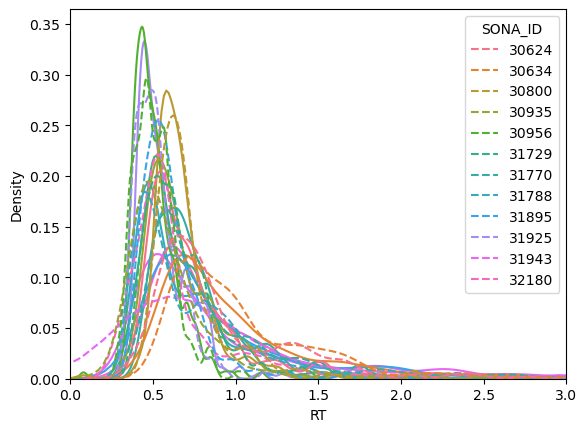

In [15]:
d = alldata_ig[~np.isnan(alldata_ig["SONA_ID"])]
d = d[~np.isin(d["SONA_ID"].values, sona_credited)]
d.loc[:, "SONA_ID"] = d["SONA_ID"].astype(int).astype(str).values
d = d.sort_values(by=["SONA_ID", "Block", "Trial"])
# d = d[[x in ["31852"] for x in d.Participant]]
sns.kdeplot(data=d[d.Block == "A"], x="RT", hue="SONA_ID", bw_adjust=0.5).set(
    xlim=(0, 3)
)
sns.kdeplot(
    data=d[d.Block == "B"], x="RT", hue="SONA_ID", bw_adjust=0.5, linestyle="--"
).set(xlim=(0, 3))
print(d["SONA_ID"].unique())
# "32009" in alldata_sub["SONA_ID"][~np.isnan(alldata_sub["SONA_ID"])].astype(str).values

In [ ]:
# Prolific ----------------------------------------------------------------
if len(prolific_ids) > 0:
    d = alldata_ig[
        [i in list(prolific_ids.keys()) for i in alldata_ig["Participant"].values]
    ]
    d.loc[:, "Participant"] = [str(prolific_ids[i]) for i in d["Participant"].values]
    # d = d[[x in ["31852"] for x in d.Participant]]
    sns.kdeplot(data=d[d.Block == "A"], x="RT", hue="Participant", bw_adjust=0.5).set(
        xlim=(0, 3)
    )
    sns.kdeplot(
        data=d[d.Block == "B"], x="RT", hue="Participant", bw_adjust=0.5, linestyle="--"
    ).set(xlim=(0, 3))
    print(np.sort([k[1] for k in prolific_ids.items()]))

Save data ==============================================================

In [ ]:
# Remove columns
alldata_sub = alldata_sub.drop(
    columns=["Browser", "Platform", "Screen_Width", "Screen_Height", "SONA_ID"]
)
alldata_ig = alldata_ig.drop(columns=["SONA_ID"])

Inspect ================================================================
alldata_sub["Experimenter"].unique()
alldata_sub["Ethnicity"].unique()

In [ ]:
# Reanonimize ============================================================
alldata_sub["d"] = pd.to_datetime(
    alldata_sub["Date"] + " " + alldata_sub["Time"], format="%d/%m/%Y %H:%M:%S"
)
alldata_sub = alldata_sub.sort_values(by=["d"]).reset_index(drop=True)
correspondance = {j: f"S{i+1:03}" for i, j in enumerate(alldata_sub["Participant"])}
alldata_sub["Participant"] = [correspondance[i] for i in alldata_sub["Participant"]]
alldata_ig["Participant"] = [correspondance[i] for i in alldata_ig["Participant"]]
alldata_sub = alldata_sub.drop(columns=["Date_OSF", "d", "Time"])  # Drop OSf column

In [ ]:
# Save
alldata_sub.to_csv("../data/rawdata_participants.csv", index=False)
alldata_ig.to_csv("../data/rawdata_IllusionGame.csv", index=False)
print("Done!")